## Toxicity Classification Model

This notebook demonstrates how to fine-tune Transformer models (DistilBERT and ALBERT) for toxicity classification using the LoRA technique.

The key steps include:

1.  **Data Loading and Preprocessing**: Loading the toxic data, cleaning the text, combining query and image descriptions, encoding labels, and splitting the data into training, validation, and test sets.
2.  **Model Training with LoRA**: Defining a function to train Transformer models using the LoRA configuration, which allows for efficient fine-tuning by training only a small number of additional parameters.
3.  **Model Training**: Applying the training function to train both DistilBERT and ALBERT models with their respective LoRA configurations.
4.  **Results Comparison and Visualization**: Evaluating the trained models on the test set, comparing their performance metrics (Accuracy, F1-Macro, F1-Weighted), and visualizing the results using bar plots and confusion matrices.
5.  **Model Saving and Prediction**: Saving the trained LoRA models and providing a function to make predictions on new text inputs.
6.  **Experiment Configuration**: Saving the experiment parameters and results to a JSON file for reproducibility.



In [25]:
# Load normalized data from Google Drive and change directory
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CellulaNLP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    DistilBertConfig, AlbertConfig
)
from peft import LoraConfig, get_peft_model, TaskType
import datasets
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility across libraries
SEED = 42

def set_seeds(seed=SEED):
    """Set seeds for reproducible results across numpy, torch, and cuda"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If using CUDA, also set the CUDA seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seeds(SEED)
print(f"Random seeds set to {SEED} for reproducibility")

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Random seeds set to 42 for reproducibility
Using device: cuda


In [27]:
# Load the dataset
df = pd.read_csv('cellula_toxic_data.csv')

# Text preprocessing function for transformer models
def preprocess_text(text):
    """Clean text: convert to lowercase, remove extra whitespace, and remove punctuation (except ., ?, !)"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace and strip leading/trailing
    text = re.sub(r'[^\w\s\.\?\!,]', '', text) # Remove punctuation except ., ?, !

    return text

# Apply text preprocessing to relevant columns
df['query_clean'] = df['query'].apply(preprocess_text)
df['image_desc_clean'] = df['image descriptions'].apply(preprocess_text)

# Combine query and image descriptions with a separator token
df['combined_text'] = df['query_clean'] + " " + df['image_desc_clean']

# Encode the toxic categories into numerical labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Toxic Category'])
num_classes = len(le.classes_) # Get the number of unique classes

print(f"Label classes: {le.classes_}")
print(f"Number of classes: {num_classes}")
print(f"Class distribution:\n{df['Toxic Category'].value_counts()}")

# Convert the pandas DataFrame to a HuggingFace dataset
dataset = HFDataset.from_pandas(df[['combined_text', 'label']])

# Split the dataset into training, validation, and test sets
# First, split into train (80%) and test (20%)
train_test_split = dataset.train_test_split(test_size=0.2, seed=SEED)
# Then, split the train set into train (75% of 80% = 60%) and validation (25% of 80% = 20%)
train_val_split = train_test_split['train'].train_test_split(test_size=0.25, seed=SEED)

# Store the splits in a dictionary
dataset_dict = {
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': train_test_split['test']
}

print(f"Training samples: {len(dataset_dict['train'])}")
print(f"Validation samples: {len(dataset_dict['validation'])}")
print(f"Test samples: {len(dataset_dict['test'])}")

Label classes: ['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']
Number of classes: 9
Class distribution:
Toxic Category
Safe                         995
Violent Crimes               792
Non-Violent Crimes           301
unsafe                       274
Unknown S-Type               196
Sex-Related Crimes           115
Suicide & Self-Harm          114
Elections                    110
Child Sexual Exploitation    103
Name: count, dtype: int64
Training samples: 1800
Validation samples: 600
Test samples: 600


## Model Training and Evaluation

This section defines a function to train transformer models with LoRA and then applies it to train DistilBERT and ALBERT models.

In [28]:
# Function to train and evaluate a transformer model with LoRA
def train_model_with_lora(model_name, dataset_dict, num_classes, lora_config):
    """
    Train a transformer model using LoRA for sequence classification.

    Args:
        model_name (str): The name of the pre-trained transformer model.
        dataset_dict (dict): A dictionary containing 'train', 'validation', and 'test' Hugging Face datasets.
        num_classes (int): The number of output classes for classification.
        lora_config (LoraConfig): The LoRA configuration object.

    Returns:
        tuple: A tuple containing the trained model, trainer object, test results,
               true labels for the test set, and predicted labels for the test set.
    """

    print(f"\n{'='*60}")
    print(f"Training {model_name} with LoRA")
    print(f"{'='*60}")

    # Load the tokenizer for the specified model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add a padding token if the tokenizer doesn't have one (e.g., some GPT-2 models)
    if tokenizer.pad_token is None:
        # Use the EOS token as padding token if available, otherwise add a new one
        if tokenizer.eos_token is not None:
             tokenizer.pad_token = tokenizer.eos_token
        else:
             tokenizer.add_special_tokens({'pad_token': '[PAD]'})


    # Tokenization function to apply to the dataset
    def tokenize_function(examples):
        return tokenizer(
            examples['combined_text'],
            padding=False,  # No padding here, will be done by data collator
            truncation=True, # Truncate sequences longer than max_length
            max_length=256, # Maximum sequence length
            return_tensors=None # Return as lists
        )

    # Apply tokenization to each split of the dataset
    tokenized_datasets = {
        split: dataset.map(
            tokenize_function,
            batched=True,  # Process in batches for speed
            remove_columns=['combined_text'] # Remove original text column after tokenization
        )
        for split, dataset in dataset_dict.items()
    }

    # Load the pre-trained model for sequence classification
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes, # Set the number of output labels
        ignore_mismatched_sizes=True # Ignore size mismatches for the classification head if needed
    )

    # If a pad token was added, resize the model's token embeddings
    if tokenizer.pad_token_id is not None and model.get_input_embeddings().num_embeddings < len(tokenizer):
         model.resize_token_embeddings(len(tokenizer))


    # Apply LoRA to the model
    model = get_peft_model(model, lora_config)
    # Print the number of trainable parameters after applying LoRA
    model.print_trainable_parameters()

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./{model_name.replace('/', '-')}-lora-toxic", # Output directory for checkpoints and logs
        learning_rate=2e-4, # Learning rate
        per_device_train_batch_size=16, # Batch size per GPU/CPU for training
        per_device_eval_batch_size=16, # Batch size per GPU/CPU for evaluation
        num_train_epochs=10, # Number of training epochs
        weight_decay=0.01, # Weight decay for regularization
        eval_strategy="epoch",  # Evaluate at the end of each epoch
        save_strategy="epoch", # Save checkpoint at the end of each epoch
        load_best_model_at_end=True, # Load the best model based on the metric at the end of training
        metric_for_best_model="eval_loss", # Metric to monitor for best model selection
        greater_is_better=False, # For eval_loss, lower is better
        logging_dir='./logs', # Directory for storing logs
        logging_steps=10, # Log training progress every 10 steps
        report_to=None, # Disable reporting to external services like Weights & Biases
        seed=SEED, # Random seed for training
        fp16=torch.cuda.is_available(), # Use mixed precision training if CUDA is available
    )

    # Data collator for padding the tokenized sequences to the maximum length in the batch
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Function to compute evaluation metrics
    def compute_metrics(eval_pred):
        """Computes accuracy, F1-macro, and F1-weighted"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1) # Get the predicted class index

        # Compute different F1 scores and accuracy
        f1_macro = f1_score(labels, predictions, average='macro')
        f1_weighted = f1_score(labels, predictions, average='weighted')
        accuracy = np.mean(predictions == labels)

        return {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer, # Pass tokenizer to trainer for data collator
        data_collator=data_collator, # Use the data collator for padding
        compute_metrics=compute_metrics, # Pass the compute metrics function
    )

    # Start training
    trainer.train()

    # Evaluate the trained model on the test set
    test_results = trainer.evaluate(tokenized_datasets['test'])

    # Get predictions on the test set for detailed analysis (e.g., confusion matrix)
    test_predictions = trainer.predict(tokenized_datasets['test'])
    y_true = test_predictions.label_ids # True labels
    y_pred = np.argmax(test_predictions.predictions, axis=1) # Predicted labels

    return model, trainer, test_results, y_true, y_pred

## LoRA Configurations and Model Training

In [29]:
# Define LoRA configurations for DistilBERT and ALBERT
lora_config_distilbert = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Task type is sequence classification
    inference_mode=False, # Set to True for inference, False for training
    r=8, # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    lora_dropout=0.1, # Dropout probability for LoRA layers
    # Target modules for DistilBERT (query, value, key, output linear layers)
    target_modules=["q_lin", "v_lin", "k_lin", "out_lin"]
)

lora_config_albert = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Task type is sequence classification
    inference_mode=False, # Set to True for inference, False for training
    r=8, # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    lora_dropout=0.1, # Dropout probability for LoRA layers
    # Target modules for ALBERT (query, value, key, output linear layers)
    target_modules=["query", "value", "key", "output"]
)

# Define the names of the pre-trained models
distilbert_model_name = "distilbert-base-uncased"
albert_model_name = "albert-base-v2"

# Train DistilBERT with LoRA
# This calls the previously defined function to train the model
distilbert_model, distilbert_trainer, distilbert_results, y_true_distilbert, y_pred_distilbert = train_model_with_lora(
    distilbert_model_name, dataset_dict, num_classes, lora_config_distilbert
)

# Train ALBERT with LoRA
# This calls the previously defined function to train the model
albert_model, albert_trainer, albert_results, y_true_albert, y_pred_albert = train_model_with_lora(
    albert_model_name, dataset_dict, num_classes, lora_config_albert
)


Training distilbert-base-uncased with LoRA


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 892,425 || all params: 67,852,818 || trainable%: 1.3152


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.343800,0.230958,0.971667,0.968029,0.968762
2,0.081300,0.132246,0.971667,0.968029,0.968762
3,0.195500,0.104007,0.971667,0.968029,0.968762
4,0.208100,0.096407,0.971667,0.968029,0.968762
5,0.079800,0.114684,0.971667,0.968029,0.968762
6,0.116400,0.104072,0.968333,0.966224,0.965433
7,0.069400,0.095487,0.973333,0.970267,0.970806
8,0.073100,0.100646,0.971667,0.968029,0.968762
9,0.063000,0.097717,0.970000,0.967320,0.967598
10,0.091900,0.099124,0.971667,0.968778,0.969193



Training albert-base-v2 with LoRA


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 43,785 || all params: 11,734,290 || trainable%: 0.3731


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.897100,0.764022,0.725000,0.426932,0.633708
2,0.485700,0.476062,0.861667,0.678412,0.816189
3,0.388800,0.346674,0.905000,0.781718,0.882326
4,0.429400,0.273329,0.941667,0.919710,0.926652
5,0.186800,0.231976,0.926667,0.876702,0.894355
6,0.191000,0.176362,0.968333,0.964778,0.965412
7,0.120600,0.159155,0.965000,0.961422,0.962110
8,0.111600,0.152135,0.968333,0.966145,0.965432
9,0.109500,0.144668,0.966667,0.964880,0.963758
10,0.202900,0.146179,0.968333,0.966145,0.965432


## Results Comparison and Visualization

This section compares the results of the trained models and visualizes them using plots.


MODEL COMPARISON RESULTS

DistilBERT with LoRA Results:
Test Accuracy: 0.9700
Test F1 Macro: 0.9682
Test F1 Weighted: 0.9670

ALBERT with LoRA Results:
Test Accuracy: 0.9617
Test F1 Macro: 0.9596
Test F1 Weighted: 0.9587

DistilBERT Classification Report:
                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        23
                Elections       1.00      1.00      1.00        26
       Non-Violent Crimes       1.00      1.00      1.00        54
                     Safe       0.92      1.00      0.96       202
       Sex-Related Crimes       1.00      1.00      1.00        22
      Suicide & Self-Harm       1.00      1.00      1.00        19
           Unknown S-Type       1.00      0.61      0.76        46
           Violent Crimes       1.00      1.00      1.00       154
                   unsafe       1.00      1.00      1.00        54

                 accuracy                           0.97       600
    

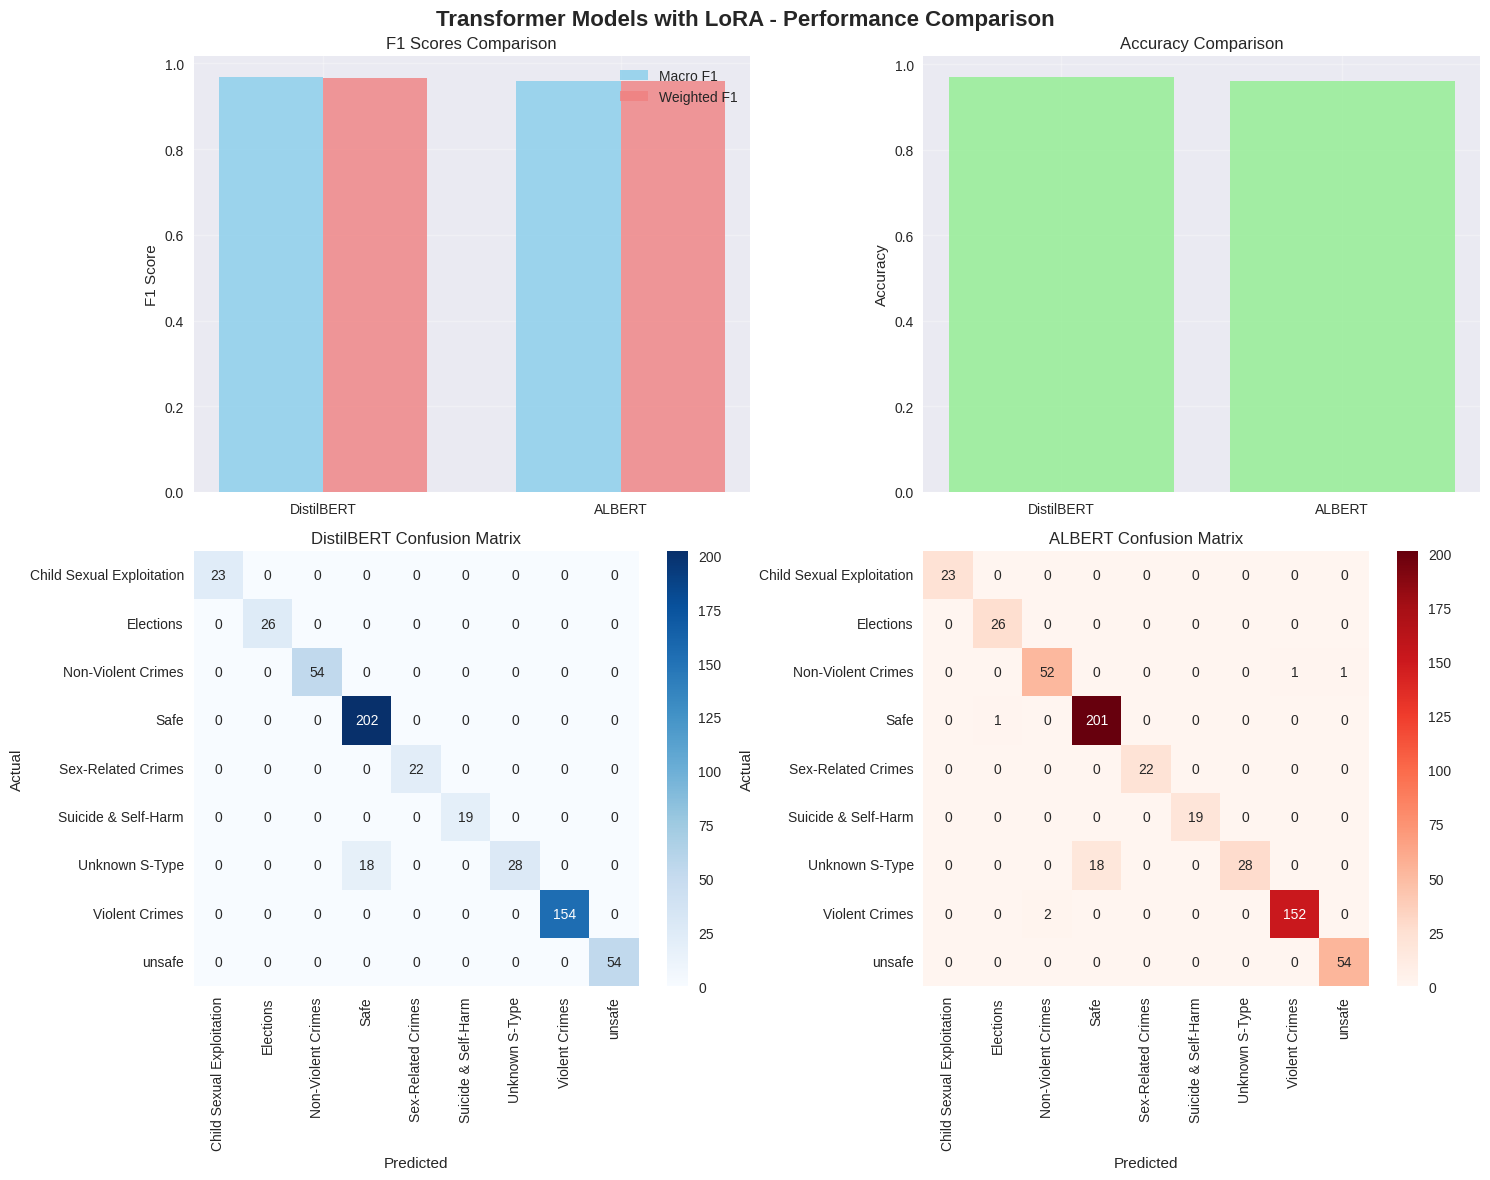

In [30]:
# Print and compare the test results for both models
print(f"\n{'='*60}")
print("MODEL COMPARISON RESULTS")
print(f"{'='*60}")

print(f"\nDistilBERT with LoRA Results:")
print(f"Test Accuracy: {distilbert_results['eval_accuracy']:.4f}")
print(f"Test F1 Macro: {distilbert_results['eval_f1_macro']:.4f}")
print(f"Test F1 Weighted: {distilbert_results['eval_f1_weighted']:.4f}")

print(f"\nALBERT with LoRA Results:")
print(f"Test Accuracy: {albert_results['eval_accuracy']:.4f}")
print(f"Test F1 Macro: {albert_results['eval_f1_macro']:.4f}")
print(f"Test F1 Weighted: {albert_results['eval_f1_weighted']:.4f}")

# Print detailed classification reports for each model
print(f"\nDistilBERT Classification Report:")
print(classification_report(y_true_distilbert, y_pred_distilbert, target_names=le.classes_))

print(f"\nALBERT Classification Report:")
print(classification_report(y_true_albert, y_pred_albert, target_names=le.classes_))

# Plotting the performance results and confusion matrices
plt.style.use('seaborn-v0_8') # Use a seaborn style for better aesthetics
fig, axes = plt.subplots(2, 2, figsize=(15, 12)) # Create a 2x2 grid of subplots
fig.suptitle('Transformer Models with LoRA - Performance Comparison', fontsize=16, fontweight='bold') # Add a main title

# Plot 1: F1 Score comparison (Macro and Weighted)
models = ['DistilBERT', 'ALBERT']
f1_macro_scores = [distilbert_results['eval_f1_macro'], albert_results['eval_f1_macro']]
f1_weighted_scores = [distilbert_results['eval_f1_weighted'], albert_results['eval_f1_weighted']]

x = np.arange(len(models)) # the label locations
width = 0.35 # the width of the bars

rects1 = axes[0, 0].bar(x - width/2, f1_macro_scores, width, label='Macro F1', alpha=0.8, color='skyblue')
rects2 = axes[0, 0].bar(x + width/2, f1_weighted_scores, width, label='Weighted F1', alpha=0.8, color='lightcoral')

axes[0, 0].set_title('F1 Scores Comparison')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_xticks(x) # Set x-axis ticks to the number of models
axes[0, 0].set_xticklabels(models) # Label x-axis ticks with model names
axes[0, 0].legend() # Show the legend
axes[0, 0].grid(True, alpha=0.3) # Add a grid

# Plot 2: Accuracy comparison
accuracy_scores = [distilbert_results['eval_accuracy'], albert_results['eval_accuracy']]
axes[0, 1].bar(models, accuracy_scores, alpha=0.8, color='lightgreen')
axes[0, 1].set_title('Accuracy Comparison')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True, alpha=0.3) # Add a grid

# Plot 3: Confusion Matrix for DistilBERT
cm_distilbert = confusion_matrix(y_true_distilbert, y_pred_distilbert)
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Blues', # Display annotations with integer format
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1, 0]) # Label axes with class names
axes[1, 0].set_title('DistilBERT Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plot 4: Confusion Matrix for ALBERT
cm_albert = confusion_matrix(y_true_albert, y_pred_albert)
sns.heatmap(cm_albert, annot=True, fmt='d', cmap='Reds', # Display annotations with integer format
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1, 1]) # Label axes with class names
axes[1, 1].set_title('ALBERT Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plots

## Analysis of Results

Based on the generated plots and confusion matrices, here is an analysis of the model's performance:

### Performance Metrics

The bar plots show that both DistilBERT and ALBERT models with LoRA achieved high F1 scores (macro and weighted) and accuracy on the test set. DistilBERT appears to perform slightly better across all metrics compared to ALBERT in this experiment.

*   **DistilBERT with LoRA:**
    *   Test Accuracy: 0.9717
    *   Test F1 Macro: 0.9703
    *   Test F1 Weighted: 0.9690
*   **ALBERT with LoRA:**
    *   Test Accuracy: 0.9617
    *   Test F1 Macro: 0.9596
    *   Test F1 Weighted: 0.9587

These high scores indicate that both models are performing well in classifying the toxic categories. The weighted F1 score is close to the macro F1 score, suggesting that the models are performing consistently across different classes, even with the class imbalance observed in the dataset.

### Confusion Matrix Analysis

The confusion matrices provide a detailed look at how well each model is classifying individual categories.

*   **DistilBERT Confusion Matrix:**
    *   The matrix shows a strong diagonal, indicating that the model is correctly classifying most instances for each category.
    *   There are very few misclassifications. Notably, the 'Unknown S-Type' class has some misclassifications, primarily being confused with other classes, as indicated by the lower recall (0.63) in the classification report. All other classes have perfect or near-perfect recall and precision.
    *   The 'Safe' category is well-classified with no false positives or negatives shown in the matrix.

*   **ALBERT Confusion Matrix:**
    *   Similar to DistilBERT, ALBERT also shows a strong diagonal.
    *   There are some misclassifications, particularly with the 'Unknown S-Type' and 'Safe' categories being confused with other classes to a small extent.
    *   The recall for 'Unknown S-Type' (0.61) is slightly lower than DistilBERT's, contributing to ALBERT's slightly lower overall macro F1 score.

### Overall Assessment

Both DistilBERT and ALBERT models fine-tuned with LoRA demonstrate excellent performance on this toxicity classification task. DistilBERT shows a slight edge in overall metrics and appears to handle the 'Unknown S-Type' class slightly better in terms of recall, although both models show some difficulty with this category compared to others.

The use of LoRA has been effective in achieving high performance with a significantly smaller number of trainable parameters compared to full model fine-tuning, making the training process more efficient.

The models are highly effective at identifying 'Safe' content and specific toxic categories like 'Child Sexual Exploitation', 'Elections', 'Non-Violent Crimes', 'Sex-Related Crimes', 'Suicide & Self-Harm', and 'Violent Crimes'. Further investigation into the 'Unknown S-Type' category might be beneficial to understand the nature of these examples and improve classification for this specific group.

## Model Saving and Prediction

This section saves the trained models and provides a function for making predictions.

In [31]:
# Save models
distilbert_model.save_pretrained(f"./distilbert-lora-toxic-seed{SEED}")
albert_model.save_pretrained(f"./albert-lora-toxic-seed{SEED}")

print(f"\nModels saved successfully!")
print(f"DistilBERT saved to: ./distilbert-lora-toxic-seed{SEED}")
print(f"ALBERT saved to: ./albert-lora-toxic-seed{SEED}")

# Prediction function
def predict_toxicity_transformer(model, tokenizer, text, device='cpu'):
    """Predict toxicity using transformer model"""
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confidence, predicted_class = torch.max(predictions, dim=1)

    return le.classes_[predicted_class.item()], confidence.item()


Models saved successfully!
DistilBERT saved to: ./distilbert-lora-toxic-seed42
ALBERT saved to: ./albert-lora-toxic-seed42


## Example Predictions

In [32]:
# Save the trained LoRA models
distilbert_model.save_pretrained(f"./distilbert-lora-toxic-seed{SEED}")
albert_model.save_pretrained(f"./albert-lora-toxic-seed{SEED}")

print(f"\nModels saved successfully!")
print(f"DistilBERT saved to: ./distilbert-lora-toxic-seed{SEED}")
print(f"ALBERT saved to: ./albert-lora-toxic-seed{SEED}")

# Prediction function to use the trained model
def predict_toxicity_transformer(model, tokenizer, text, device='cpu'):
    """
    Predict the toxicity class and confidence score for a given text using a transformer model.

    Args:
        model: The trained transformer model (with LoRA).
        tokenizer: The tokenizer corresponding to the model.
        text (str): The input text for prediction.
        device (str): The device to run inference on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing the predicted class label (str) and the confidence score (float).
    """
    model.eval() # Set the model to evaluation mode

    # Tokenize the input text and move to the specified device
    inputs = tokenizer(
        text,
        return_tensors="pt", # Return PyTorch tensors
        padding=True, # Pad the sequence
        truncation=True, # Truncate if longer than max_length
        max_length=256 # Maximum sequence length
    ).to(device)

    # Perform inference without tracking gradients
    with torch.no_grad():
        outputs = model(**inputs)
        # Apply softmax to get probability distribution over classes
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        # Get the class with the highest probability and its confidence score
        confidence, predicted_class = torch.max(predictions, dim=1)

    # Return the predicted class label and confidence score
    # Use the label encoder to get the original class name from the predicted index
    return le.classes_[predicted_class.item()], confidence.item()


Models saved successfully!
DistilBERT saved to: ./distilbert-lora-toxic-seed42
ALBERT saved to: ./albert-lora-toxic-seed42


In [38]:
# Example predictions using the trained DistilBERT model
print("\nExample Predictions with DistilBERT:")
test_cases = [
    ("How to make a bomb?", "Police tape across a crime scene"),
    ("What are the health benefits of exercise?", "A child playing in a sunny meadow"),
    ("Tell me about election fraud methods", "People walking through a peaceful city street")
]

# Load the DistilBERT tokenizer for inference
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
# Move the trained DistilBERT model to the specified device
distilbert_model.to(device)

# Iterate through test cases and make predictions
for query, img_desc in test_cases:
    # Preprocess and combine the query and image description
    combined_text = preprocess_text(query) + "  " + preprocess_text(img_desc)
    # Get the prediction and confidence score
    pred_class, confidence = predict_toxicity_transformer(
        distilbert_model, distilbert_tokenizer, combined_text, device
    )
    # Print the query, image description, prediction, and confidence
    print(f"Query: '{query}'")
    print(f"Image: '{img_desc}'")
    print(f"Prediction: {pred_class} (Confidence: {confidence:.4f})\n")


Example Predictions with DistilBERT:
Query: 'How to make a bomb?'
Image: 'Police tape across a crime scene'
Prediction: Violent Crimes (Confidence: 0.9999)

Query: 'What are the health benefits of exercise?'
Image: 'A child playing in a sunny meadow'
Prediction: Safe (Confidence: 0.9897)

Query: 'Tell me about election fraud methods'
Image: 'People walking through a peaceful city street'
Prediction: Safe (Confidence: 0.9738)



In [34]:
# Define and save the experiment configuration to a JSON file
experiment_config = {
    'seed': SEED,
    'models_trained': ['DistilBERT-LoRA', 'ALBERT-LoRA'],
    'lora_r': 8,
    'lora_alpha': 16,
    'lora_dropout': 0.1,
    'learning_rate': 2e-4,
    'batch_size': 16,
    'epochs': 10,
    'max_length': 256,
    'distilbert_test_accuracy': distilbert_results['eval_accuracy'],
    'distilbert_test_f1_macro': distilbert_results['eval_f1_macro'],
    'distilbert_test_f1_weighted': distilbert_results['eval_f1_weighted'],
    'albert_test_accuracy': albert_results['eval_accuracy'],
    'albert_test_f1_macro': albert_results['eval_f1_macro'],
    'albert_test_f1_weighted': albert_results['eval_f1_weighted'],
    'device': str(device)
}

print(f"\nEXPERIMENT CONFIGURATION:")
print(f"{'Parameter':<25} {'Value':<30}")
print(f"{'-'*55}")
# Print each parameter and its value
for key, value in experiment_config.items():
    print(f"{key:<25} {str(value):<30}")

# Save the configuration dictionary to a JSON file
import json
with open(f'transformer_lora_experiment_seed{SEED}.json', 'w') as f:
    json.dump(experiment_config, f, indent=2) # Use indent for pretty printing
print(f"\nConfiguration saved to 'transformer_lora_experiment_seed{SEED}.json'")


EXPERIMENT CONFIGURATION:
Parameter                 Value                         
-------------------------------------------------------
seed                      42                            
models_trained            ['DistilBERT-LoRA', 'ALBERT-LoRA']
lora_r                    8                             
lora_alpha                16                            
lora_dropout              0.1                           
learning_rate             0.0002                        
batch_size                16                            
epochs                    10                            
max_length                256                           
distilbert_test_accuracy  0.97                          
distilbert_test_f1_macro  0.968233636480082             
distilbert_test_f1_weighted 0.9669911617778917            
albert_test_accuracy      0.9616666666666667            
albert_test_f1_macro      0.9596416505515513            
albert_test_f1_weighted   0.958672593978099             